In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
##
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
##
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE




In [3]:
##
sample_data=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
# train_data.shape,test_data.shape
sample_data

##

,id,target
0,0,no
1,1,no
2,2,no
3,3,yes
4,4,yes
...,...,...
9995,9995,yes
9996,9996,no
9997,9997,no
9998,9998,no


In [4]:
test_data

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2010-11-20,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,NaN
9996,2009-06-03,26,admin.,single,secondary,no,317,yes,no,NaN,953,1,-1,0,NaN
9997,2010-04-20,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,NaN
9998,2010-02-17,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,NaN


In [5]:
# Handle any infinity values by replacing them with NaN
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values if any or drop rows with NaN
train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

In [6]:
train_data

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,other,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,other,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,other,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,failure,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,failure,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,cellular,56,8,-1,0,failure,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,failure,no


In [7]:
test_data

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,cellular,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2010-11-20,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,failure
9996,2009-06-03,26,admin.,single,secondary,no,317,yes,no,cellular,953,1,-1,0,failure
9997,2010-04-20,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,failure
9998,2010-02-17,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,failure


# EDA


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                39211 non-null  object
 3   marital            39211 non-null  object
 4   education          39211 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            39211 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           39211 non-null  object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
me

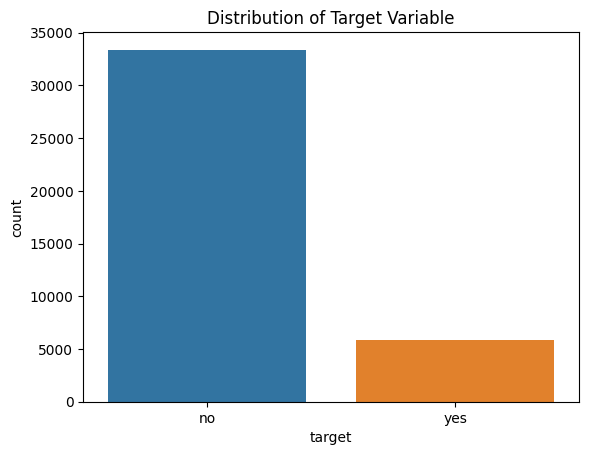



Summary of Numerical Features:
                age        balance      duration      campaign         pdays  \
count  39211.000000   39211.000000  39211.000000  39211.000000  39211.000000   
mean      42.120247    5441.781719    439.062789      5.108770     72.256051   
std       12.709352   16365.292065    769.096291      9.890153    160.942593   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      98.000000    109.000000      1.000000     -1.000000   
50%       40.000000     549.000000    197.000000      2.000000     -1.000000   
75%       50.000000    2030.000000    380.000000      4.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous  
count  39211.000000  
mean      11.826171  
std       44.140259  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


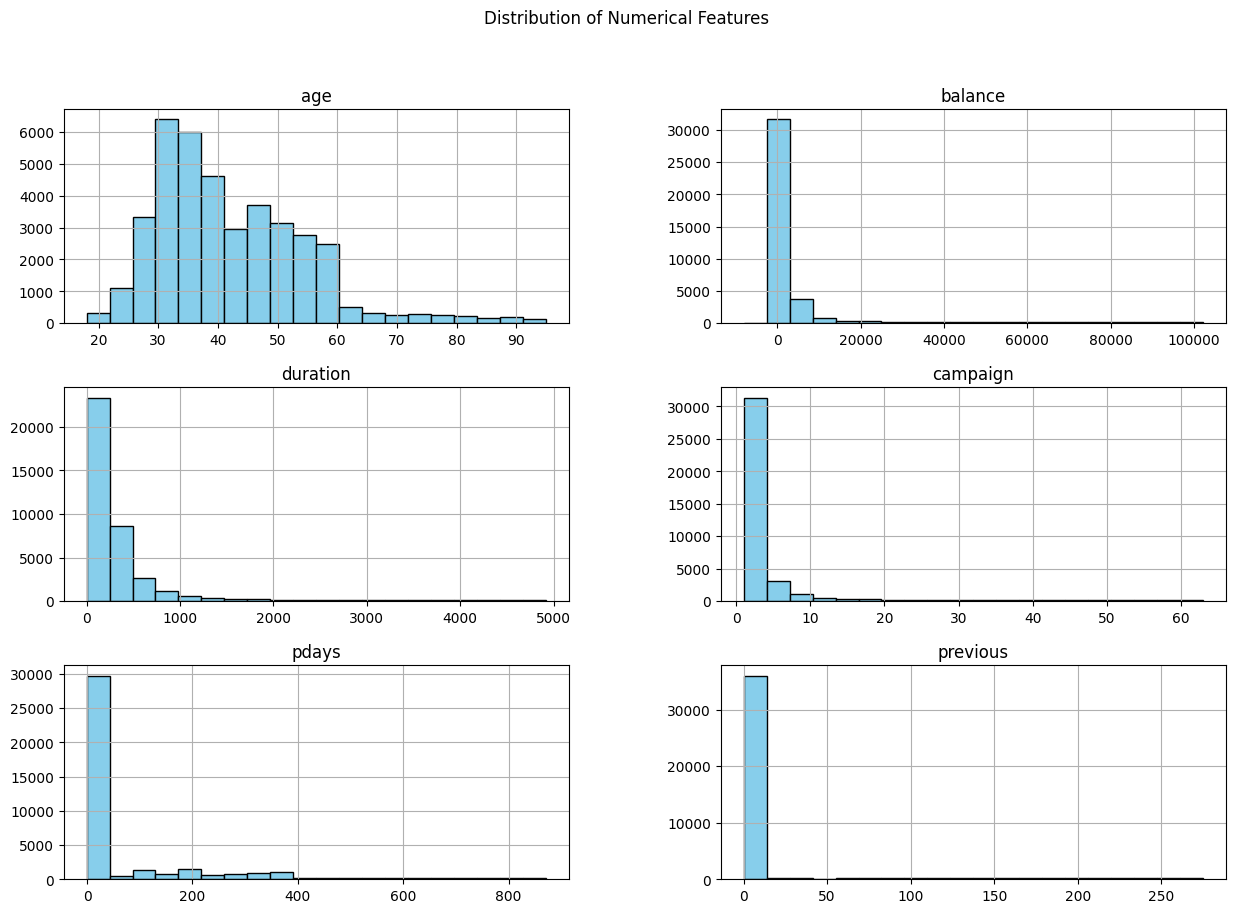

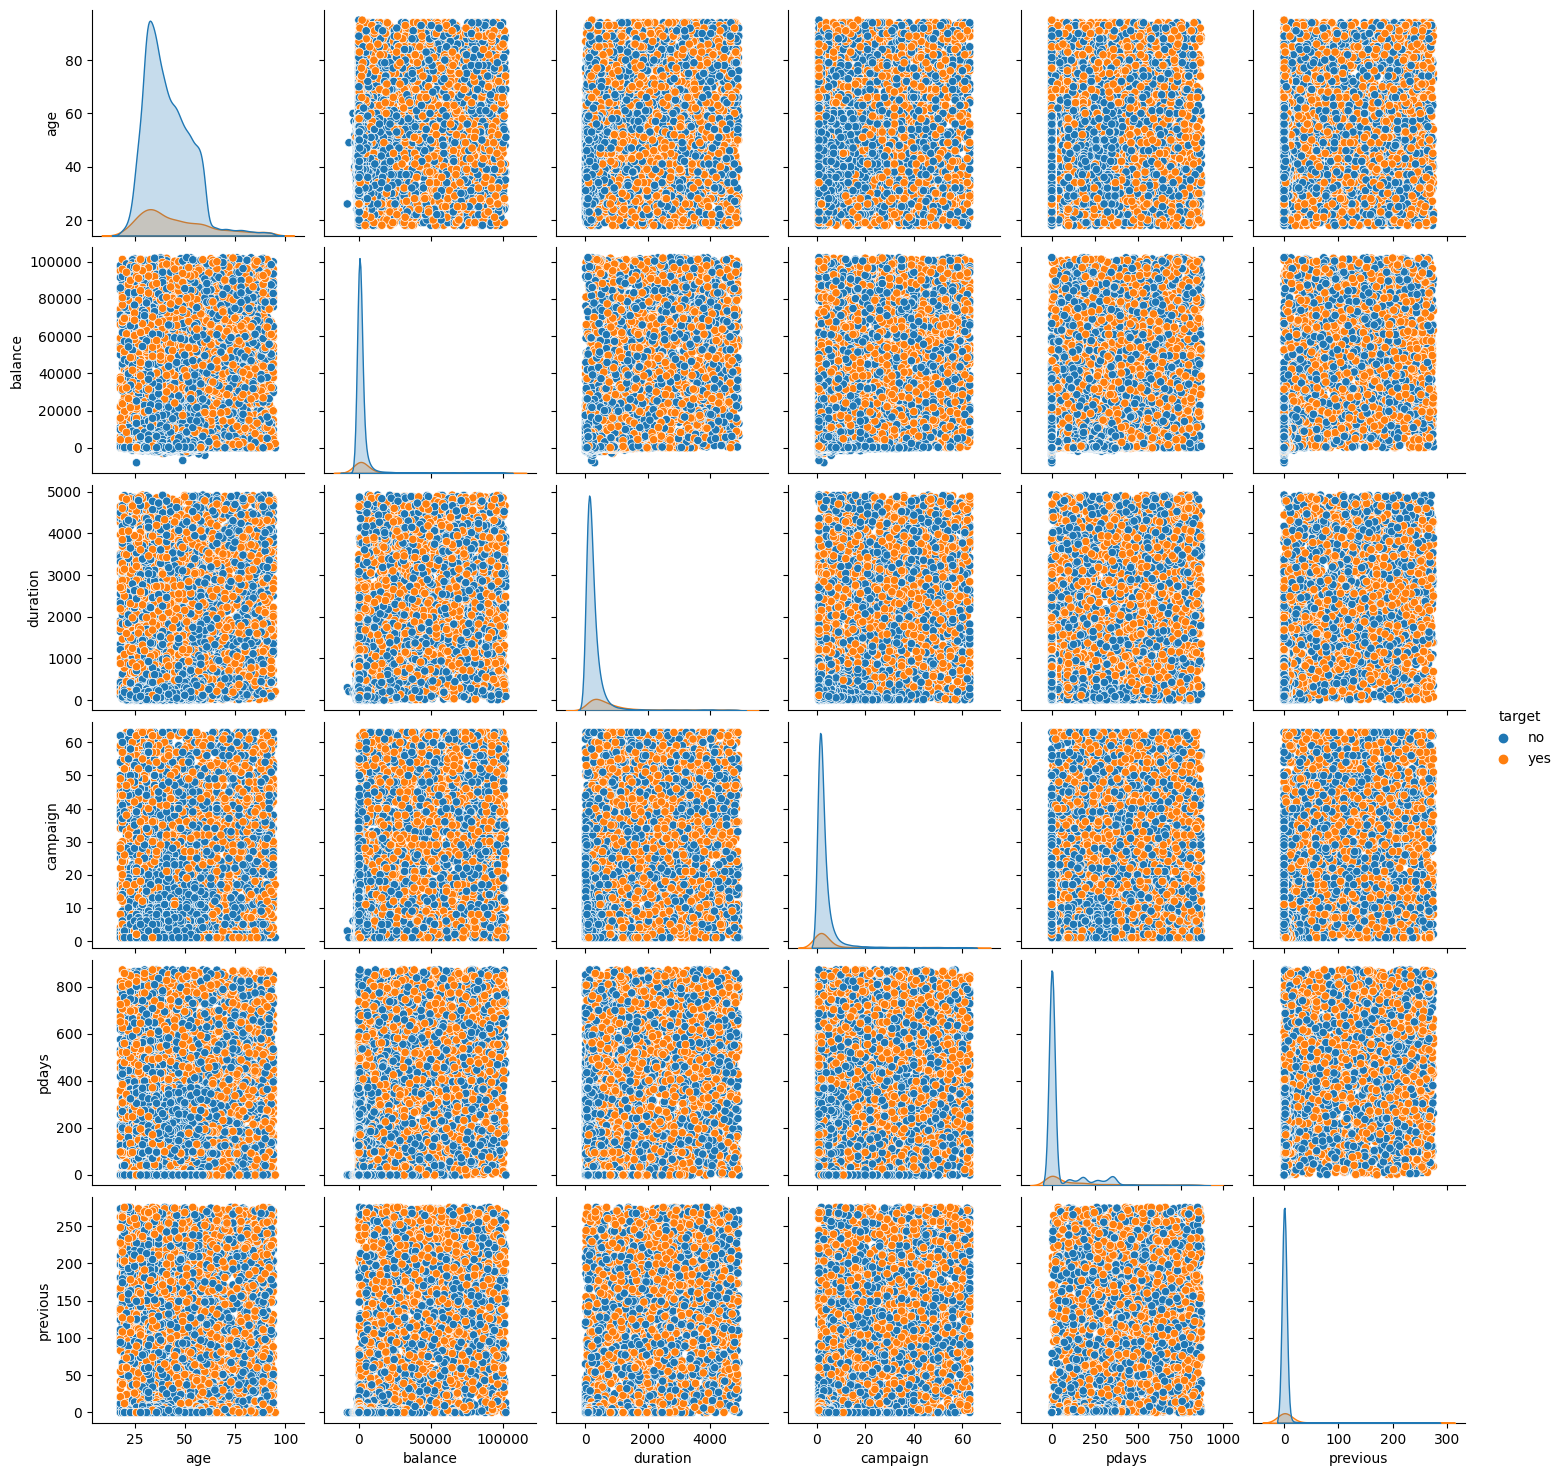



Categorical Features Summary:
job Distribution:


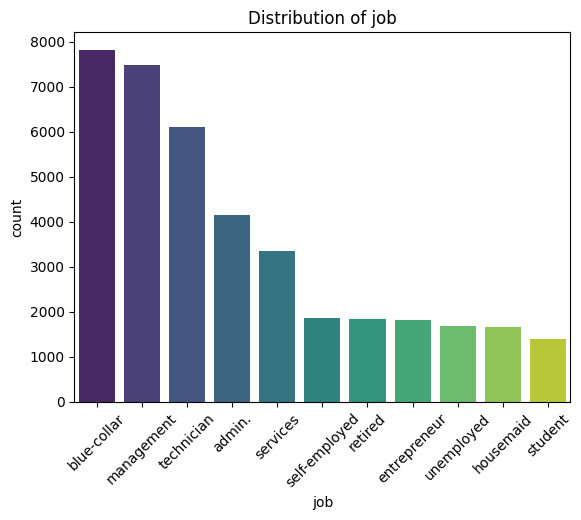

marital Distribution:


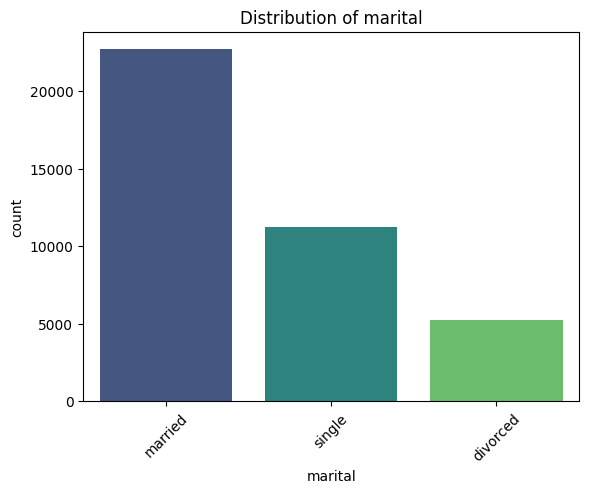

education Distribution:


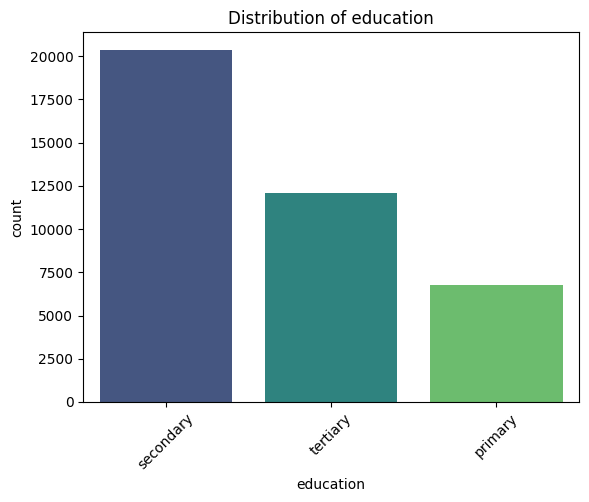

default Distribution:


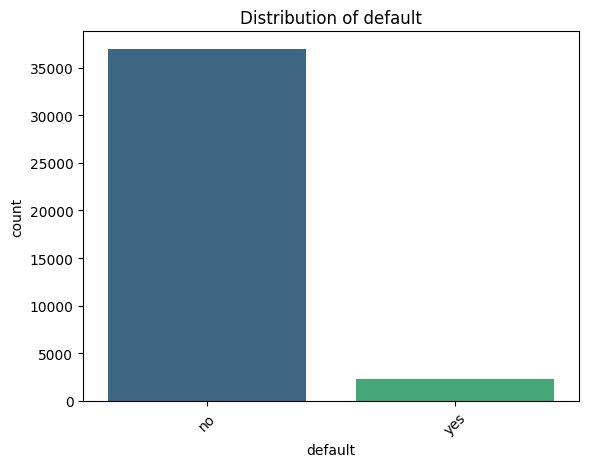

housing Distribution:


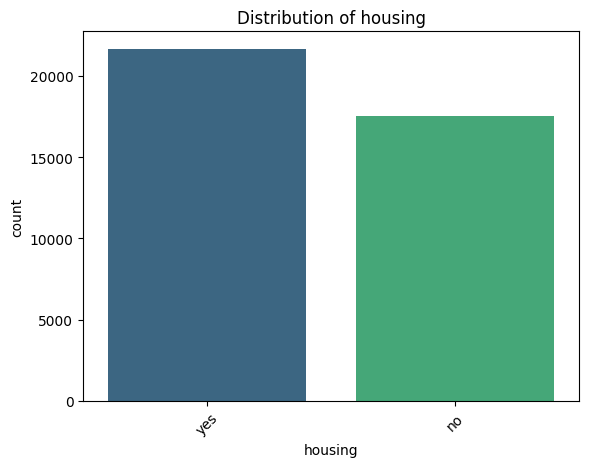

loan Distribution:


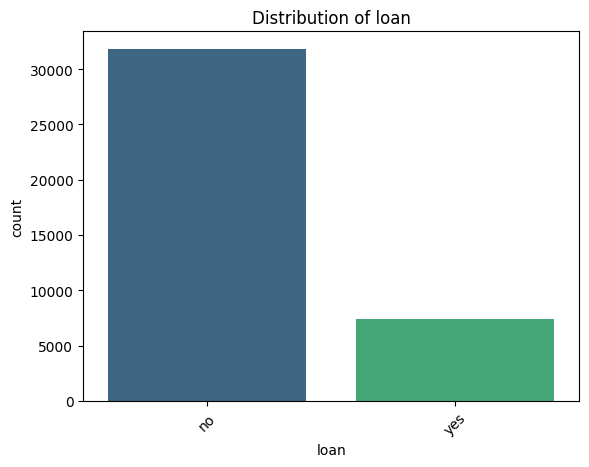

contact Distribution:


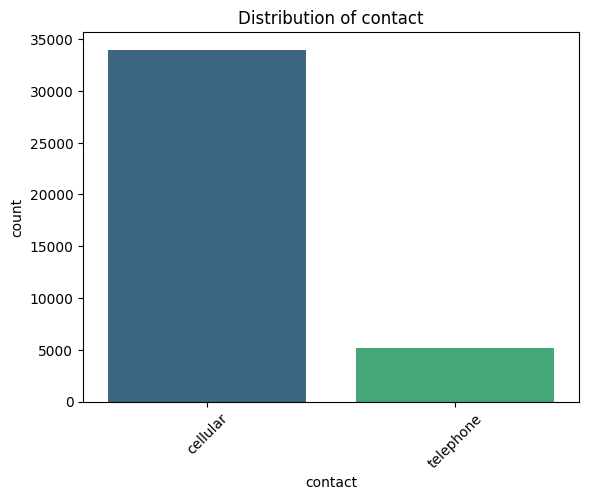

poutcome Distribution:


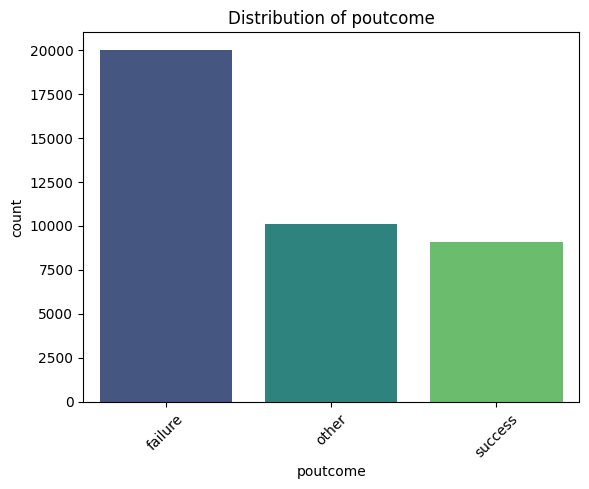



Key Observations:
Most common job category: blue-collar
Proportion of people with housing loans: housing
yes    0.55232
no     0.44768
Name: proportion, dtype: float64
Average duration of successful calls (target='yes'): 1071.0775699330702 seconds


In [8]:
# EDA Section
# 1. General Information
print("Dataset Info:")
train_data.info()

print("\n\nSummary Statistics:")
print(train_data.describe())

print("\n\nSample Data:")
print(train_data.head())

# 2. Missing Values
print("\n\nMissing Values:")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])

# 3. Target Distribution
print("\n\nTarget Distribution:")
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

# 4. Numerical Features Analysis
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

print("\n\nSummary of Numerical Features:")
print(train_data[numerical_cols].describe())

# Plot histograms for numerical features
train_data[numerical_cols].hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Pairplot for numerical features (optional, if computationally feasible)
sns.pairplot(train_data, vars=numerical_cols, hue='target', diag_kind='kde')
plt.show()

# # Correlation Heatmap
# print("\nCorrelation Heatmap:")
# plt.figure(figsize=(10, 6))
# correlation_matrix = train_data[numerical_cols + ['target']].corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title("Correlation Between Numerical Features and Target")
# plt.show()

# 5. Categorical Features Analysis
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

print("\n\nCategorical Features Summary:")
for col in categorical_cols:
    print(f"{col} Distribution:")
    sns.countplot(x=col, data=train_data, order=train_data[col].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

# 6. Insights and Observations
# Analyze key patterns in the data
print("\n\nKey Observations:")
print(f"Most common job category: {train_data['job'].value_counts().idxmax()}")
print(f"Proportion of people with housing loans: {train_data['housing'].value_counts(normalize=True)}")
print(f"Average duration of successful calls (target='yes'): {train_data[train_data['target'] == 'yes']['duration'].mean()} seconds")

# 7. Temporal Features (if available)
# if 'last contact date' in train_data.columns:
#     train_data['last contact date'] = pd.to_datetime(train_data['last contact date'])
#     train_data['month'] = train_data['last contact date'].dt.month
#     train_data['weekday'] = train_data['last contact date'].dt.weekday

    # print("\nTemporal Insights:")
    # sns.countplot(x='month', data=train_data, hue='target', palette='coolwarm')
    # plt.title('Target Distribution Across Months')
    # plt.show()

    # sns.countplot(x='weekday', data=train_data, hue='target', palette='coolwarm')
    # plt.title('Target Distribution Across Weekdays')
    # plt.show()


In [9]:
# X_test

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                39211 non-null  object
 3   marital            39211 non-null  object
 4   education          39211 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            39211 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           39211 non-null  object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [11]:
train_data

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,other,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,other,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,other,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,failure,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,failure,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,cellular,56,8,-1,0,failure,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,failure,no


In [12]:
test_data

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,cellular,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2010-11-20,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,failure
9996,2009-06-03,26,admin.,single,secondary,no,317,yes,no,cellular,953,1,-1,0,failure
9997,2010-04-20,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,failure
9998,2010-02-17,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,failure


# 1st step

# Feature Engineering

In [13]:
train_data['last contact date'] = pd.to_datetime(train_data['last contact date'])
train_data['month'] = train_data['last contact date'].dt.month
train_data['year'] = train_data['last contact date'].dt.year
train_data['weekday'] = train_data['last contact date'].dt.weekday


test_data['last contact date'] = pd.to_datetime(test_data['last contact date'])
test_data['month'] = test_data['last contact date'].dt.month
test_data['year'] = test_data['last contact date'].dt.year
test_data['weekday'] = test_data['last contact date'].dt.weekday

# train_data.drop(columns=['last contact date'],inplace=True)
test_data.drop(columns=['last contact date'],inplace=True)


categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']



In [14]:
# test_data

# 2nd step

# Preprocessing


In [15]:
# Step 2: Encode categorical features

train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)

# Step 3: Normalize numerical features
scaler = StandardScaler()
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])

# Step 4: Handle target imbalance (if necessary)
X = train_data.drop('target', axis=1)
y = train_data['target'].apply(lambda x: 1 if x == 'yes' else 0)

# Handle datetime columns
for col in X.select_dtypes(include=['datetime64']).columns:
    X[col] = X[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Data preprocessing complete!")

Data preprocessing complete!


In [16]:
# # Preprocessing for numerical features
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
#     ('scaler', StandardScaler())  # Scale numerical features
# ])

# # Preprocessing for categorical features
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
# ])

# # Combine preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),  # Replace with your numerical columns
#         ('cat', categorical_transformer, categorical_cols)  # Replace with your categorical columns
#     ]
# )

# # Apply preprocessing to the entire dataset before SMOTE
# X_preprocessed = preprocessor.fit_transform(train_data.drop(columns=['target']))  # Replace 'target' with your actual target column name
# y = train_data['target'].apply(lambda x: 1 if x == 'yes' else 0)

# # Convert preprocessed data to a DataFrame if needed for SMOTE compatibility
# X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray() if hasattr(X_preprocessed, 'toarray') else X_preprocessed)

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_preprocessed_df, y)

# # Split the balanced data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# # Define the pipeline for classification
# pipeline = Pipeline(steps=[
#     ('classifier', RandomForestClassifier(random_state=42))  # Model step
# ])

# # Train the pipeline on the resampled training data
# pipeline.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = pipeline.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.4f}')

# # Detailed evaluation
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# 3rd step

# Model selection & evalution


**Best Model**


In [17]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_predd = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_train, y_predd)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Train Accuracy: 99.71%
Test Accuracy: 92.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      6548
           1       0.90      0.95      0.93      6806

    accuracy                           0.92     13354
   macro avg       0.93      0.92      0.92     13354
weighted avg       0.92      0.92      0.92     13354


Confusion Matrix:
[[5864  684]
 [ 334 6472]]


In [18]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200, 300, 400],        # Number of trees
#     'max_depth': [10, 20, 30, None],                 # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],                 # Minimum samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],                   # Minimum samples required at a leaf node
#     'max_features': ['sqrt', 'log2', None]           # Number of features to consider when looking for the best split
# }

# # Initialize Random Forest model
# rf_model = RandomForestClassifier(random_state=42)

# # Use RandomizedSearchCV for hyperparameter tuning
# random_search = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_grid,
#     n_iter=50,                   # Number of parameter settings sampled
#     scoring='f1',                # Optimize for F1 score
#     cv=5,                        # 5-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1                    # Use all processors
# )

# # Fit the random search model
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", random_search.best_params_)
# print("Best F1 Score:", random_search.best_score_)

# # Evaluate the tuned model on the test set
# best_rf_model = random_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_rf_model.predict(X_test)

# # Evaluate the tuned model
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# print("\nTest Accuracy after Hyperparameter Tuning: {:.2f}%".format(accuracy * 100))
# print("F1 Score after Hyperparameter Tuning: {:.4f}".format(f1))

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# print("\nConfusion Matrix:")
# conf_matrix = confusion_matrix(y_test, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix - Tuned Random Forest')
# plt.show()


**This is the output after Hyperparameter Tunning**


Best F1 Score: 0.9247840026937478

Test Accuracy after Hyperparameter Tuning: 92.74%
F1 Score after Hyperparameter Tuning: 0.9306

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      6548
           1       0.91      0.95      0.93      6806

    accuracy                           0.93     13354
   macro avg       0.93      0.93      0.93     13354
weighted avg       0.93      0.93      0
.93     13354


XGBoost Model Performance:
Accuracy: 91.87%
F1 Score: 0.9207
ROC AUC: 0.9792

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      6548
           1       0.91      0.93      0.92      6806

    accuracy                           0.92     13354
   macro avg       0.92      0.92      0.92     13354
weighted avg       0.92      0.92      0.92     13354


Confusion Matrix:


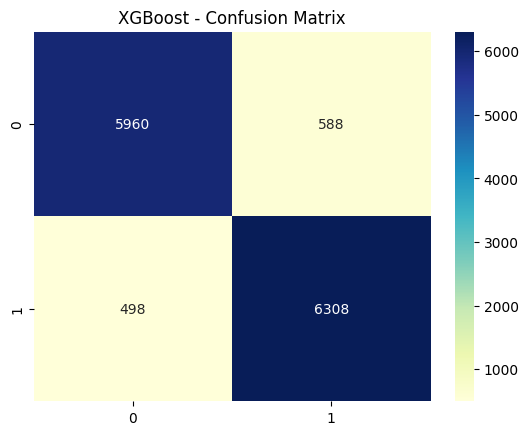

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


# Initialize the XGBoost model with basic hyperparameters
xgb_model = XGBClassifier(
    random_state=42,
    objective='binary:logistic',  # Since this is a binary classification problem
    eval_metric='logloss',
    use_label_encoder=False
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # For ROC AUC

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_prob_xgb)

# Print the results
print("\nXGBoost Model Performance:")
print(f"Accuracy: {xgb_accuracy * 100:.2f}%")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"ROC AUC: {xgb_auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='YlGnBu')
plt.title("XGBoost - Confusion Matrix")
plt.show()



Logistic Regression Model Performance:
Accuracy: 49.03%
F1 Score: 0.0000
ROC AUC: 0.4879

Confusion Matrix for Logistic Regression:


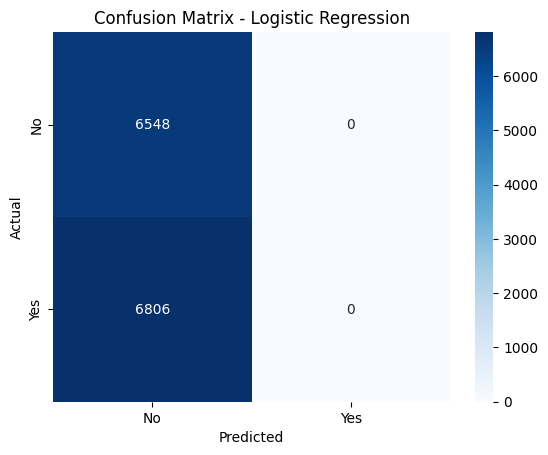

In [20]:
# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the Logistic Regression model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the Logistic Regression model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_prob_lr)

# Print the results
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {lr_accuracy * 100:.2f}%")
print(f"F1 Score: {lr_f1:.4f}")
print(f"ROC AUC: {lr_auc:.4f}")

# Display the Confusion Matrix
print("\nConfusion Matrix for Logistic Regression:")
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


# 4th step

In [21]:
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# Align test data columns with training data
test_data_final = test_data.reindex(columns=X_train.columns, fill_value=0)


In [22]:
train_data

,last contact date,age,balance,duration,campaign,pdays,previous,target,month,year,...,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_other,poutcome_success
0,2009-04-17,-1.268393,-0.292989,-0.106702,-0.314334,1.607699,-0.245271,no,4,2009,...,True,False,True,False,False,True,False,False,True,False
1,2009-10-11,0.777371,-0.298732,-0.362850,-0.415446,-0.455175,-0.267926,no,10,2009,...,True,False,True,False,False,True,False,True,True,False
2,2010-11-20,0.147905,-0.247159,-0.147009,-0.415446,-0.455175,-0.267926,no,11,2010,...,True,False,True,False,False,False,False,False,True,False
3,2009-09-01,-0.717610,-0.308448,-0.435663,-0.213222,-0.455175,-0.267926,no,9,2009,...,True,False,True,False,False,True,False,True,True,False
4,2008-01-29,-0.874977,-0.324152,0.007720,-0.314334,-0.455175,-0.267926,no,1,2008,...,False,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,-0.874977,-0.332524,-0.550085,2.921249,-0.455175,-0.267926,no,7,2008,...,False,True,True,False,False,True,False,False,False,False
39207,2009-07-31,1.328153,0.045537,-0.422661,-0.112110,-0.455175,-0.267926,no,7,2009,...,True,False,False,False,False,False,False,False,False,False
39208,2008-06-02,-0.481561,-0.328674,-0.498075,0.292338,-0.455175,-0.267926,no,6,2008,...,True,False,True,False,False,True,False,False,False,False
39209,2010-03-20,-1.111027,0.028977,-0.449966,-0.010998,-0.455175,-0.267926,no,3,2010,...,False,True,True,False,False,False,False,False,False,False


In [23]:
test_data

,age,balance,duration,campaign,pdays,previous,month,year,weekday,job_blue-collar,...,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_other,poutcome_success
0,-0.481561,-0.332096,-0.544884,-0.415446,-0.455175,-0.267926,11,2009,5,False,...,False,True,False,True,False,False,False,False,False,False
1,-0.953660,-0.267324,-0.469470,-0.314334,-0.455175,-0.267926,2,2010,3,False,...,True,False,False,True,False,False,False,False,False,False
2,-0.796294,-0.327513,-0.459068,-0.112110,-0.455175,-0.267926,7,2010,2,True,...,False,True,True,False,False,True,False,False,False,False
3,-0.324194,-0.241660,-0.139208,-0.314334,-0.455175,-0.267926,6,2010,2,False,...,True,False,False,False,False,False,False,False,False,False
4,1.328153,-0.313276,0.197555,-0.415446,0.644610,-0.222615,3,2008,6,False,...,True,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.324194,0.214555,-0.179515,-0.415446,-0.455175,-0.267926,11,2010,5,False,...,False,True,False,True,False,False,True,False,False,False
9996,-1.268393,-0.313153,0.668244,-0.415446,-0.455175,-0.267926,6,2009,2,False,...,False,True,True,False,False,True,False,False,False,False
9997,-1.268393,-0.321464,-0.365450,-0.314334,-0.455175,-0.267926,4,2010,1,False,...,False,True,True,False,False,False,False,False,False,False
9998,-0.796294,-0.313459,-0.269232,-0.314334,-0.455175,-0.267926,2,2010,2,False,...,False,True,False,True,False,False,False,False,False,False


In [24]:
# # Preprocess the test data using the preprocessor
# test_data_preprocessed = preprocessor.transform(test_data)

# # Convert preprocessed test data to a DataFrame for alignment if needed
# test_data_final = pd.DataFrame(
#     test_data_preprocessed.toarray() if hasattr(test_data_preprocessed, 'toarray') else test_data_preprocessed,
#     columns=preprocessor.get_feature_names_out()
# )

# # Align test data columns with the training data
# test_data_final = test_data_final.reindex(columns=X_train.columns, fill_value=0)

# 5th step

In [25]:
# Y_pred = model.predict(test_data_final)
Y_pred = rf_model.predict(test_data_final)
# Y_pred = best_rf_model.predict(test_data_final)

# Y_pred = xgb_model.predict(test_data_final)
# Y_pred = lr_model.predict(test_data_final)
# Y_pred = pipeline.predict(test_data_final)
y_pred = ['yes' if pred == 1 else 'no' for pred in Y_pred]

# Load sample submission and add predictions
sample = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

sample['target'] = y_pred
# Save to CSV
sample.to_csv("submission.csv", index=False)

##